# Bert Classifier for First ICU Prediction

## Import & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
import pickle

In [3]:
from utils.plots import *
from utils.metrics import BinaryAvgMetrics, get_best_model
from args import args
vars(args)

{'workdir': PosixPath('../data/work_dir/bert'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'bert_model': 'bert-base-mimic-cased',
 'modeldir': PosixPath('../data/work_dir/bert/models'),
 'bert_dir': PosixPath('../pretrained/pytorch-bert/bert-base-mimic-cased'),
 'max_seq_len': 256,
 'do_lower_case': False,
 'bs': 32,
 'device': 'cuda:0',
 'start_seed': 127,
 'cols': ['class_label', 'note'],
 'lr': 5e-05,
 'n_epochs': 5,
 'wd': 0.1,
 'warmup_prop': 0.1,
 'gradient_accumulation_steps': 1,
 'loss_scale': 0,
 'do_train': True,
 'do_eval': True,
 'bc_threshold': 0.1,
 'num_labels': 1,
 'labels': [0, 1],
 'n_gpu': 4}

## Metrics

The models trained with training data that was split with seeds 159 and 169, whose predictions were found at index 32 and 42, had all their predictions at as class 1. This resulted in zero TN and FN and ended up with a NaN NPV. So, these were removed resulting in 98 runs instead of 100.

In [ ]:
with open(args.workdir/f'preds_ori.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

for i, (targ, pred, prob) in enumerate(zip(targs, preds, probs)):
  if np.all(pred == pred[0]):
    print(f"pred {pred[0]}, idx: {i}")

targs = [j for i, j in enumerate(targs) if i not in [32, 42]]
preds = [j for i, j in enumerate(preds) if i not in [32, 42]]
probs = [j for i, j in enumerate(probs) if i not in [32, 42]]

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

In [4]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)
  
fnames = [f'bert_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)] 

In [5]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

Number of Runs: 98
Average Prevalence of positive class: 0.236

In [6]:
get_best_model(bam, fnames)

,Value,Model File
sensitivity,0.917576,bert_seed_175.pkl
specificity,0.807254,bert_seed_144.pkl
ppv,0.544395,bert_seed_183.pkl
auroc,0.868451,bert_seed_224.pkl
npv,0.956219,bert_seed_175.pkl
f1,0.632330,bert_seed_224.pkl


In [7]:
bam.get_avg_metrics()

,Value,Definition
sensitivity,0.773,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.763,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.504,"When it PREDICTS YES, how often is it correct?"
auroc,0.852,Indicates how well the model is capable of distinguishing between classes
npv,0.916,"When it PREDICTS NO, how often is it correct?"
f1,0.610,Harmonic mean of sensitivity and ppv


In [10]:
bam.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper,Confidence,Definition
sensitivity,0.765,0.773,0.781,0.95,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.755,0.763,0.771,0.95,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.499,0.504,0.510,0.95,"When it PREDICTS YES, how often is it correct?"
npv,0.914,0.916,0.919,0.95,"When it PREDICTS NO, how often is it correct?"


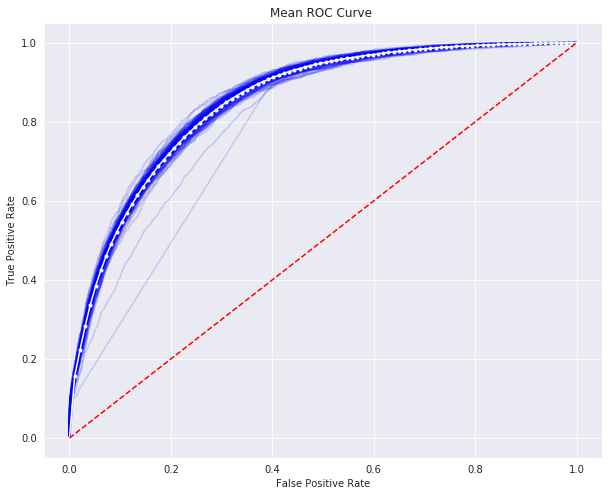

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

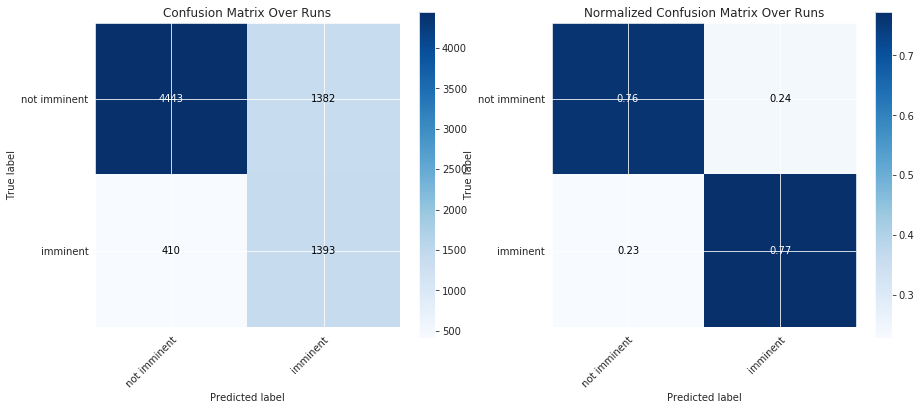

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()